# Tutorial

In [1]:
import snntorch as snn
import torch
import torch.nn as nn
from snntorch import spikeplot as splt
from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import utils.network as network
import torch.optim as optim
import os
from PIL import Image
import torchvision.transforms.functional as TF
import cv2
import pandas as pd
import time
import utils.data as dt
import utils.kalman as kalman


# os.environ["CUDA_LAUNCH_BLOCKING"] = "1" # for debugging on GPU
%load_ext autoreload
%autoreload 2
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'


## Training best performing model snippet

Loading dataset from data\simulator\dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109

Loading dataset from data\simulator\dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequences in data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24

Loading dataset from data\simulator\dataset_python_sim with accumulation time 10ms
Loaded 20632 rows from data/simulator/dataset_python_sim/positions_in_fov_10ms.csv
Found 156 sequ

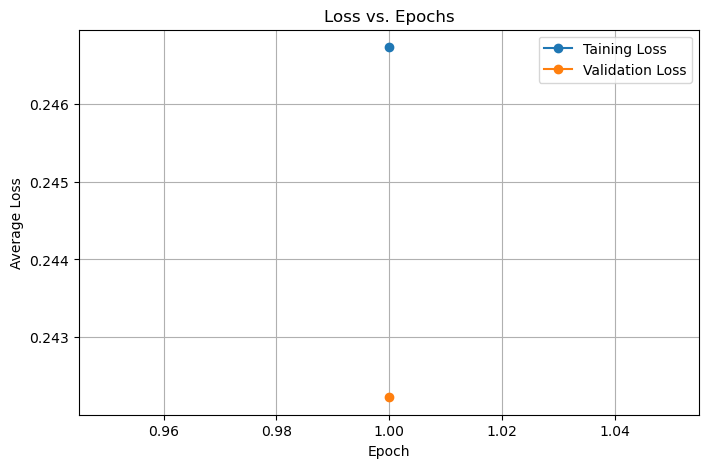

Evaluating video classification tracker
Average Error for x_cam: 47.4965 pixels
Average Error for y_cam: 4.5554 pixels
Average Error for R_cam: 1.3118 pixels
Loading best model...
Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101
Best model evaluation...
Evaluating video classification tracker


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\utils\network.py:2406: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  # Create model instance w

Average Error for x_cam: 45.9355 pixels
Average Error for y_cam: 4.5845 pixels
Average Error for R_cam: 1.0848 pixels
Best model error: 46.17646670425252
Model saved at models/VideoClassification_q8_5ts_1e.pt
Average inference time per image over 20 batches: 0.011240 s


In [ ]:
# Dataloader creation
dataset_path = r'data\simulator\dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 4
dataset_type = 'all' # This means we are using all the data, not just throws or rolls
positions_csv = f'data/simulator/dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv' # This means that the positions are in the field of view of the camera.
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=positions_csv, quantization = quantization, split='train', dataset_type=dataset_type, augment=True)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=positions_csv, quantization = quantization, split='test', dataset_type=dataset_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=positions_csv, quantization = quantization, split='val', dataset_type=dataset_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)

# Model creation
model = network.SCNNVideoClassification(trainset_in, weighted_avg=False, learn_threshold=True).to(device)
model.ordinal = False
model.name += f'-{dataset_type}_aug_lt' # This is to show that we are using augmentation of the training data and also learning the threshold.

# Training
''' 
The training evaluates the model after every epoch on the validation set and records the best model based on the validation loss. If the validation loss improves, the best model is overwritten.
The save_best_model function saves the current best model for the training and evaluates it on the test set.
'''
num_steps = 5
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-3)
num_epochs = 30
loss_function = network.classification_loss
print(f"Training with num_steps={num_steps}")
model.start_training(trainloader_in, optimizer, device, loss_function=loss_function, validationloader=valid_loader_in, num_steps=num_steps, num_epochs=num_epochs, chunk_size=30)
network.save_best_model(network.SCNNVideoClassification, testloader_in, device, evaluate=True)

# Measure inference time
inf_time = network.measure_inference_time_per_image_for_videos(model, trainloader_in, device=device, num_steps=4, num_batches=20)


## Kalman Filter Integration

In [2]:
# Create dataloaders
'''
The dataloaders are created for the different datasets. The `dataset_all` is used for all the data, while `dataset_in` is used for the data in the field of view of the camera. The `dataset_world` is used for the world coordinates ground truth.
'''

dataset_path = r'data\simulator\dataset_python_sim2'
accumulation_time = 10 # ms
quantization = 8
batch_size = 4
dataset_type = "all"
goal_type = "all" # "goal", "throw", "roll", "all"
labels = ['x_cam', 'y_cam', 'R_cam']#, 'in_fov']
new_positions_csv = f'data/simulator/dataset_python_sim2/positions_in_fov_{accumulation_time}ms.csv'
dataset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='all', dataset_type=dataset_type, goal_type=goal_type)
dataloader_in = DataLoader(dataset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=dataset_in.collate_fn)

labels_world = ['x', 'y', 'z']
dataset_world = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, quantization = 32, label_quantization=1, split='all', dataset_type=dataset_type, goal_type=goal_type, labels=labels_world)
dataloader_world = DataLoader(dataset_world, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=dataset_world.collate_fn)

# We select the datasets and dataloaders
dataloader = dataloader_in
dataset = dataloader.dataset
dataloader_world = dataloader_world

# Load the best model
model = network.load_model('models/BEST-VideoClassification_q8_5ts_38e.pt', network.SCNNVideoClassification, dataset, device)

# Load predictions
all_preds = network.get_preds_all_videos(model, dataloader, device=device, num_steps=4) # I am using num_steps=4 instead of 5 for inference because similar accuracy is achieved and it is faster to compute.



Loading dataset from data\simulator\dataset_python_sim2 with accumulation time 10ms
Loaded 12254 rows from data/simulator/dataset_python_sim2/positions_in_fov_10ms.csv
Found 87 sequences in data/simulator/dataset_python_sim2/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Final dataset split='all' size: 87

Loading dataset from data\simulator\dataset_python_sim2 with accumulation time 10ms
Loaded 12657 rows from data\simulator\dataset_python_sim2\positions_10ms.csv
Found 87 sequences in data\simulator\dataset_python_sim2\positions_10ms.csv
Shape of the images: torch.Size([2, 22, 40])
Number of label fields: 3
Final dataset split='all' size: 87

Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\utils\network.py:2405: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(p

### Evaluate Cutoff Distances

Evaluating Kalman Filter with cutoff distance: 1
Using cutoff distance: 1 meters.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 50.61it/s]
C:\Users\realenriquem\AppData\Local\Temp\ipykernel_6652\591066828.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_distances = pd.concat([df_distances, pd.DataFrame([new_row_distances])], ignore_index=True)
C:\Users\realenriquem\AppData\Local\Temp\ipykernel_6652\591066828.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_stop_accuracy = pd.concat([df_stop_accuracy, pd.DataFrame([new_row_stop_accuracy])], ignor


Confusion matrix:
          Pred_in  Pred_out
True_in        32         4
True_out        5        26

Overall accuracy: 0.866
--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 2
Using cutoff distance: 2 meters.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 51.63it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in        32         2
True_out        5        26

Overall accuracy: 0.892
--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 3
Using cutoff distance: 3 meters.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 52.58it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in        32         2
True_out        6        25

Overall accuracy: 0.877
--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 4
Using cutoff distance: 4 meters.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 54.87it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in        30         2
True_out        8        23

Overall accuracy: 0.841
--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 5
Using cutoff distance: 5 meters.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 55.66it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in        19         6
True_out        5        22

Overall accuracy: 0.788
--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 6
Using cutoff distance: 6 meters.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 60.75it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in        27         4
True_out       15        13

Overall accuracy: 0.678
--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 7
Using cutoff distance: 7 meters.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 59.65it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in         7         1
True_out        2         7

Overall accuracy: 0.824
--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 8
Using cutoff distance: 8 meters.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 70.77it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in        12         4
True_out       14         9

Overall accuracy: 0.538
--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 9
Using cutoff distance: 9 meters.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 73.29it/s]


Confusion matrix:
          Pred_in  Pred_out
True_in         8         1
True_out        4         3

Overall accuracy: 0.688
--------------------------------------------------
  cutoff_distance  mean_diff_x  mean_diff_y  mean_diff_z num_trajectories  \
0               1     0.137631     0.021146     0.079947               32   
1               2     0.145376     0.021097     0.083635               32   
2               3     0.124901     0.021222     0.079671               32   
3               4     0.189449     0.026925     0.084493               30   
4               5     0.304267     0.036491     0.126989               19   
5               6     0.332390     0.037115     0.094251               27   
6               7     0.369030     0.098954     0.291294                7   
7               8     0.373798     0.056644     0.105288               12   
8               9     0.512619     0.063676     0.043811                8   

   mean_diff_t  accuracy  
0     0.249375  0.86567

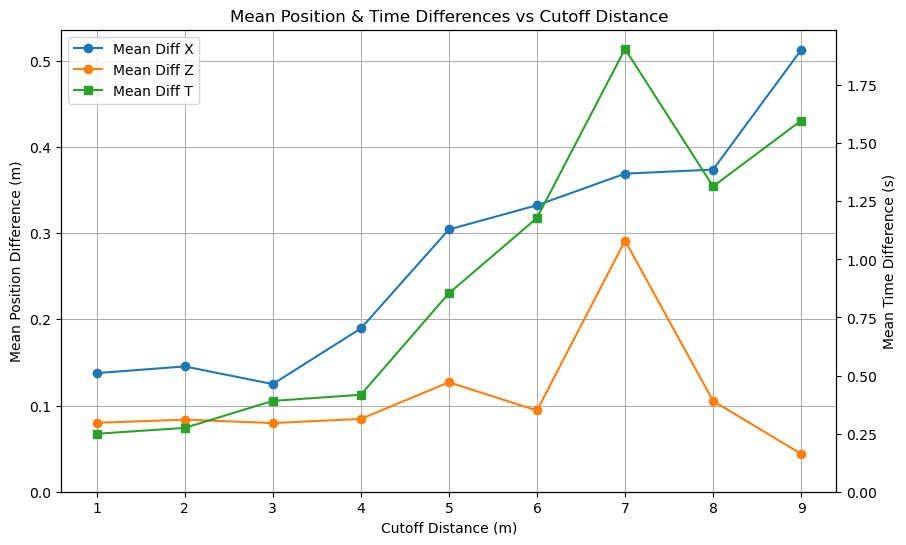

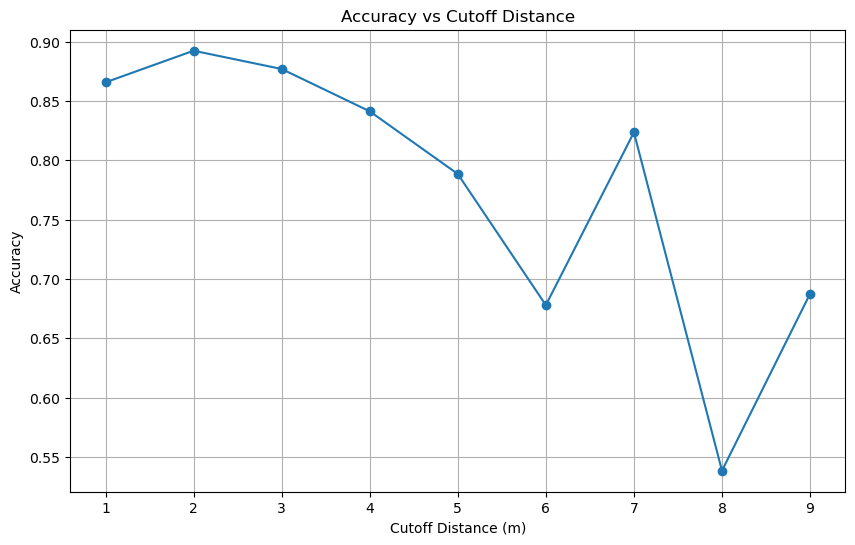

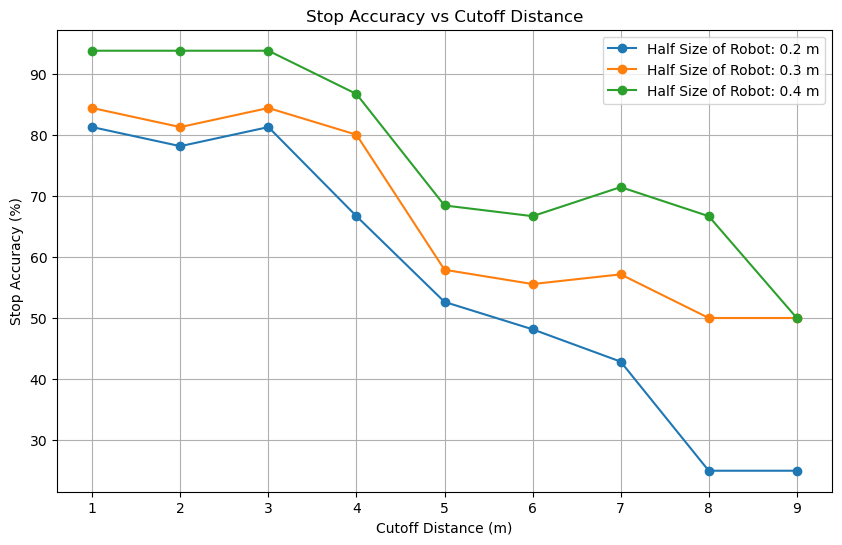

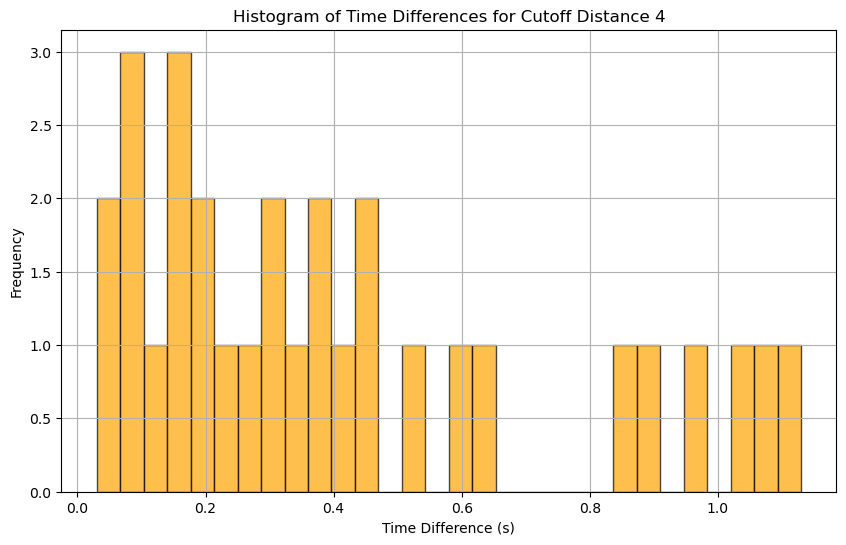

In [6]:
cutoff_distances = [1, 2, 3, 4, 5, 6, 7, 8, 9]
df_distances = pd.DataFrame(columns=['cutoff_distance', 'mean_diff_x', 'mean_diff_y', 'mean_diff_z', 'num_trajectories'])
df_stop_accuracy = pd.DataFrame(columns=['cutoff_distance', 'stop_accuracy', 'half_size_of_robot'])
conf_matrices = {}
half_sizes = [0.2, 0.3, 0.4]
for cutoff_distance in cutoff_distances:
    print(f"Evaluating Kalman Filter with cutoff distance: {cutoff_distance}")
    diffs, conf_mt, accuracy = kalman.evaluate_kf(dataloader, dataloader_world, model, device, cutoff_distance = cutoff_distance, all_preds=all_preds)
    conf_matrices[cutoff_distance] = conf_mt
    # Percentage of trajectories for which diff_x is less than 0.2
    new_row_distances = {
        'cutoff_distance': cutoff_distance,
        'mean_diff_x': diffs[:, 0].mean(),
        'mean_diff_y': diffs[:, 1].mean(),
        'mean_diff_z': diffs[:, 2].mean(),
        'mean_diff_t': diffs[:, 3].mean(),
        'accuracy': accuracy,
        'num_trajectories': len(diffs),
    }
    df_distances = pd.concat([df_distances, pd.DataFrame([new_row_distances])], ignore_index=True)
    for half_size_of_robot in half_sizes:
        stop_accuracy = (diffs[:, 0] < half_size_of_robot).mean() * 100
        new_row_stop_accuracy = {
            'cutoff_distance': cutoff_distance,
            'stop_accuracy': stop_accuracy,
            'half_size_of_robot': half_size_of_robot
        }
        df_stop_accuracy = pd.concat([df_stop_accuracy, pd.DataFrame([new_row_stop_accuracy])], ignore_index=True)
    print('-'*50)
    if cutoff_distance == 4:
        diffs4 = diffs
print(df_distances)

# Plot mean diff_x and t
fig, ax1 = plt.subplots(figsize=(10, 6))
x = df_distances['cutoff_distance']
y1 = df_distances['mean_diff_x']
y3 = df_distances['mean_diff_z']
yt = df_distances['mean_diff_t']
# Left axis: spatial differences
ax1.plot(x, y1, marker='o', label='Mean Diff X')
# ax1.plot(x, df_distances['mean_diff_y'], marker='o', label='Mean Diff Y')
ax1.plot(x, y3, marker='o', label='Mean Diff Z')
ax1.set_xlabel('Cutoff Distance (m)')
ax1.set_ylabel('Mean Position Difference (m)')
ax1.grid(True)
ax1.set_ylim(bottom=0)  # Set y-axis to start from 0

# Twin axis for time difference
ax2 = ax1.twinx()
ax2.plot(x, yt, marker='s', color='tab:green', label='Mean Diff T')
ax2.set_ylabel('Mean Time Difference (s)')
ax2.set_ylim(bottom=0)  # Set y-axis to start from 0

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Mean Position & Time Differences vs Cutoff Distance')
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(df_distances['cutoff_distance'], df_distances['accuracy'], marker='o', label='Accuracy')
plt.title('Accuracy vs Cutoff Distance')
plt.xlabel('Cutoff Distance (m)')
plt.ylabel('Accuracy')
plt.grid()

# Plot stop accuracy
plt.figure(figsize=(10, 6))
for half_size_of_robot in half_sizes:
    df_distances_filtered = df_stop_accuracy[df_stop_accuracy['half_size_of_robot'] == half_size_of_robot]
    plt.plot(df_distances_filtered['cutoff_distance'], df_distances_filtered['stop_accuracy'], marker='o', label = f'Half Size of Robot: {half_size_of_robot} m')
plt.title('Stop Accuracy vs Cutoff Distance')
plt.legend()
plt.xlabel('Cutoff Distance (m)')
plt.ylabel('Stop Accuracy (%)')
plt.grid()

# Plot histogram of time diffs for cutoff distance 4
plt.figure(figsize=(10, 6))
plt.hist(diffs4[:, 3], bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('Histogram of Time Differences for Cutoff Distance 4')
plt.xlabel('Time Difference (s)')
plt.ylabel('Frequency')
plt.grid()



### Evaluate Cutoff Times

Evaluating Kalman Filter with cutoff time: 0.5
Using cutoff time: 0.5 seconds.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 65.08it/s]
C:\Users\realenriquem\AppData\Local\Temp\ipykernel_6652\3255900551.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_time = pd.concat([df_time, pd.DataFrame([new_row])], ignore_index=True)
C:\Users\realenriquem\AppData\Local\Temp\ipykernel_6652\3255900551.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_stop_accuracy = pd.concat([df_stop_accuracy, pd.DataFrame([new_row_stop_accuracy])], ignore_index=True)



Confusion matrix:
          Pred_in  Pred_out
True_in         4         4
True_out        9        10

Overall accuracy: 0.519
--------------------------------------------------
Evaluating Kalman Filter with cutoff time: 1
Using cutoff time: 1 seconds.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 66.62it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in        15         1
True_out        7         8

Overall accuracy: 0.742
--------------------------------------------------
Evaluating Kalman Filter with cutoff time: 1.5
Using cutoff time: 1.5 seconds.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 66.98it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in        12         1
True_out        2         8

Overall accuracy: 0.870
--------------------------------------------------
Evaluating Kalman Filter with cutoff time: 2
Using cutoff time: 2 seconds.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 73.40it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in        10         1
True_out        2         6

Overall accuracy: 0.842
--------------------------------------------------
Evaluating Kalman Filter with cutoff time: 2.5
Using cutoff time: 2.5 seconds.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 83.24it/s] 



Confusion matrix:
          Pred_in  Pred_out
True_in         6         1
True_out        2         2

Overall accuracy: 0.727
--------------------------------------------------
Evaluating Kalman Filter with cutoff time: 3
Using cutoff time: 3 seconds.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 82.29it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in         4         0
True_out        1         2

Overall accuracy: 0.857
--------------------------------------------------
   cutoff_time  mean_diff_x  mean_diff_y  mean_diff_z num_trajectories  \
0          0.5     0.236488     0.010997     0.011737                4   
1          1.0     0.231004     0.014078     0.016324               15   
2          1.5     0.111347     0.007223     0.011431               12   
3          2.0     0.145511     0.006653     0.008181               10   
4          2.5     0.144332     0.008471     0.012547                6   
5          3.0     0.154145     0.006811     0.010708                4   

   mean_diff_t  accuracy  
0     1.107500  0.518519  
1     1.052667  0.741935  
2     0.491667  0.869565  
3     0.374000  0.842105  
4     0.420000  0.727273  
5     0.792500  0.857143  


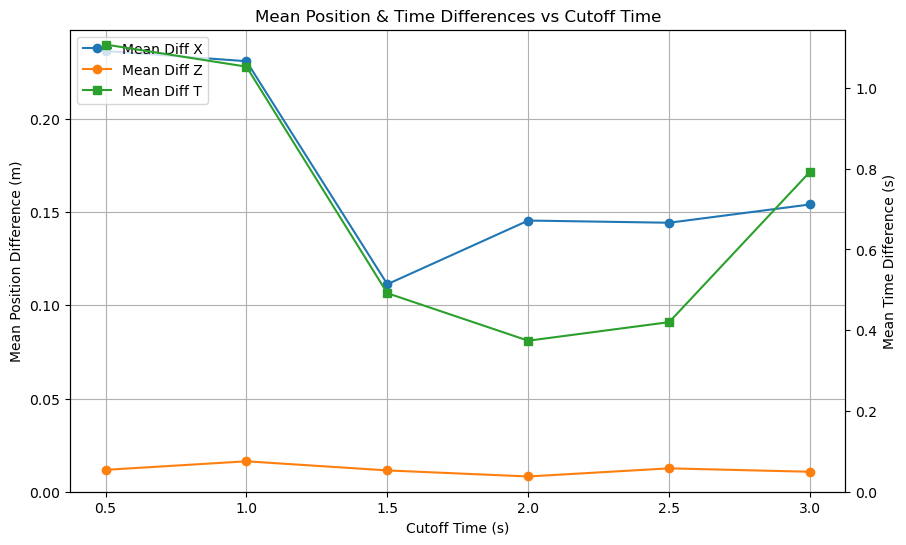

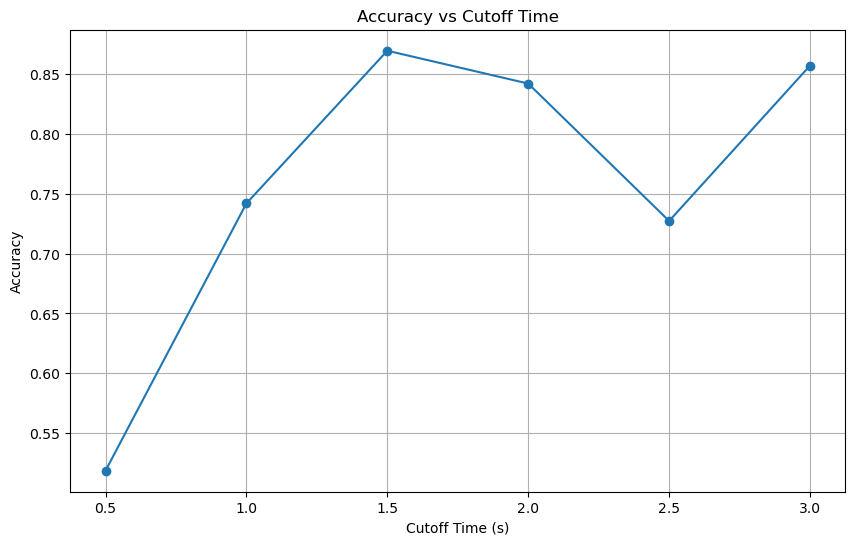

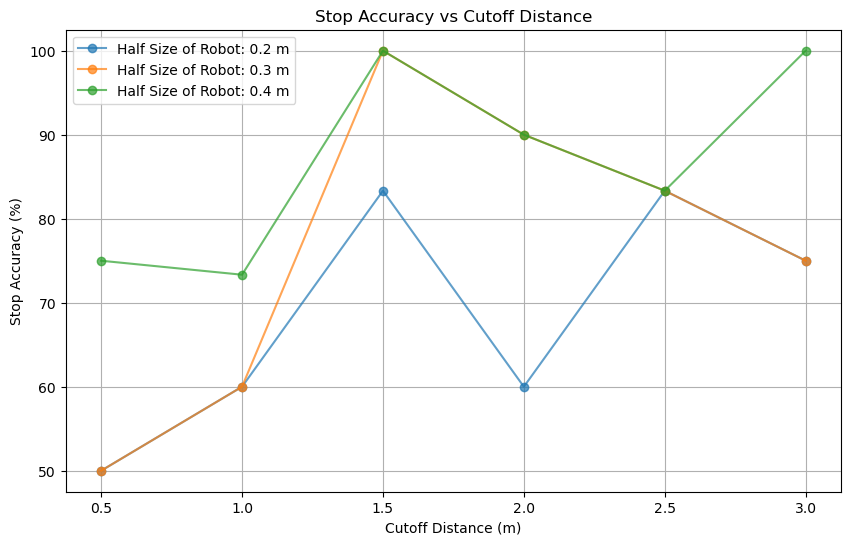

In [13]:
cutoff_times = [0.5, 1, 1.5, 2, 2.5, 3]
half_sizes = [0.2, 0.3, 0.4]
df_time = pd.DataFrame(columns=['cutoff_time', 'mean_diff_x', 'mean_diff_y', 'mean_diff_z', 'num_trajectories'])
df_stop_accuracy = pd.DataFrame(columns=['cutoff_distance', 'stop_accuracy', 'half_size_of_robot'])
conf_matrices_time = {}
all_diffs_x = []
for cutoff_time in cutoff_times:
    print(f"Evaluating Kalman Filter with cutoff time: {cutoff_time}")
    diffs, conf_mt, accuracy = kalman.evaluate_kf(dataloader, dataloader_world, model, device, cutoff_time = cutoff_time, all_preds=all_preds)
    conf_matrices_time[cutoff_time] = conf_mt
    stop_accuracy = (diffs[:, 0] < half_size_of_robot).mean() * 100
    new_row = {
        'cutoff_time': cutoff_time,
        'mean_diff_x': diffs[:, 0].mean(),
        'mean_diff_y': diffs[:, 1].mean(),
        'mean_diff_z': diffs[:, 2].mean(),
        'mean_diff_t': diffs[:, 3].mean(),
        'accuracy': accuracy,
        'num_trajectories': len(diffs),
    }
    df_time = pd.concat([df_time, pd.DataFrame([new_row])], ignore_index=True)
    for half_size_of_robot in half_sizes:
        stop_accuracy = (diffs[:, 0] < half_size_of_robot).mean() * 100
        new_row_stop_accuracy = {
            'cutoff_time': cutoff_time,
            'stop_accuracy': stop_accuracy,
            'half_size_of_robot': half_size_of_robot
        }
        df_stop_accuracy = pd.concat([df_stop_accuracy, pd.DataFrame([new_row_stop_accuracy])], ignore_index=True)
    all_diffs_x.extend(diffs[:, 0])
    print('-'*50)
print(df_time)

# Plot mean diff_x and t
fig, ax1 = plt.subplots(figsize=(10, 6))
x = df_time['cutoff_time']
y1 = df_time['mean_diff_x']
y3 = df_time['mean_diff_z']
yt = df_time['mean_diff_t']
# Left axis: spatial differences
ax1.plot(x, y1, marker='o', label='Mean Diff X')
# ax1.plot(x, df_time['mean_diff_y'], marker='o', label='Mean Diff Y')
ax1.plot(x, y3, marker='o', label='Mean Diff Z')
ax1.set_xlabel('Cutoff Time (s)')
ax1.set_ylabel('Mean Position Difference (m)')
ax1.grid(True)
ax1.set_ylim(bottom=0)  # Set y-axis to start from 0
# Twin axis for time difference
ax2 = ax1.twinx()
ax2.plot(x, yt, marker='s', color='tab:green', label='Mean Diff T')
ax2.set_ylabel('Mean Time Difference (s)')
ax2.set_ylim(bottom=0)  # Set y-axis to start from 0
# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
plt.title('Mean Position & Time Differences vs Cutoff Time')
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(df_time['cutoff_time'], df_time['accuracy'], marker='o', label='Accuracy')
plt.title('Accuracy vs Cutoff Time')
plt.xlabel('Cutoff Time (s)')
plt.ylabel('Accuracy')
plt.grid()

# Plot stop accuracy
plt.figure(figsize=(10, 6))
for half_size_of_robot in half_sizes:
    df_distances_filtered = df_stop_accuracy[df_stop_accuracy['half_size_of_robot'] == half_size_of_robot]
    plt.plot(df_distances_filtered['cutoff_time'], df_distances_filtered['stop_accuracy'], marker='o', alpha = 0.7, label = f'Half Size of Robot: {half_size_of_robot} m')
plt.title('Stop Accuracy vs Cutoff Distance')
plt.legend()
plt.xlabel('Cutoff Distance (m)')
plt.ylabel('Stop Accuracy (%)')
plt.grid()